In [1]:
import numpy as np
import online_utils as utils
import matplotlib.pyplot as plt
import pycle.sketching as sk
import pycle.compressive_learning as cl
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.sparse.linalg import eigsh
from sklearn.datasets import fetch_openml

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Initialisation

In [2]:
# Load dataset
X_, y_ = fetch_openml('Fashion-MNIST', return_X_y=True)
X_, y_ = X_.values, y_.values.astype(int)
num_classes = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [3]:
classes = [4, 9]
k = len(classes)

mask = np.zeros(y_.shape[0], dtype=bool)
for j in classes:
    mask |= (y_ == j)
X, y = X_[mask], y_[mask]
X -= np.mean(X, axis=0) # centering
for i, j in enumerate(np.sort(classes)):
    y[y == j] = i
T, p = X.shape

In [4]:
# Memory
M = 24000

In [5]:
y_est = np.zeros((4, y.size), dtype=int)
c_err = np.zeros(4)

# Computations

In [6]:
# Offline
K = X@X.T/p # kernel matrix
eigvals, eigvecs = eigsh(K, k=1, which='LA') # dominant eigenvalue/eigenvector
y_est[0] = np.where(eigvecs[:, -1] > 0, 0, 1) # class estimation
c_err[0], _, _ = utils.get_classif_error(k, y_est[0], y)

In [7]:
# Streaming
n, L = utils.best_nL(M, p)
print("n = {}\nL = {}".format(n, L))

class_count, (lbda, w, partition_ite, time_ite) = utils.pm1_streaming((lambda t: X[t]), T, n, p, L, k)
y_est[1] = np.argmax(class_count, axis=1) # estimate classes via majority vote
c_err[1], _, _ = utils.get_classif_error(k, y_est[1], y)

n = 82
L = 28


100%|██████████| 14000/14000 [00:50<00:00, 275.31it/s]


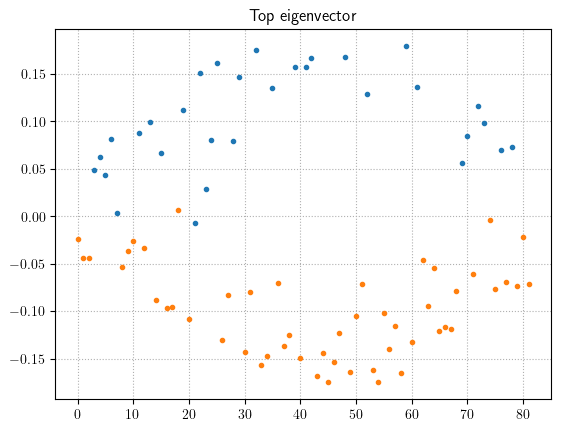

In [8]:
t = T//2
xx = np.arange(n)
for j in range(k):
    mask = (y[t-n+1:t+1] == j)
    plt.plot(xx[mask], w[t][mask], ls='', marker='.', color='C'+str(j))
plt.title("Top eigenvector")
plt.grid(ls=':')

In [9]:
# Batch
L_ = int(np.round((p/2)*(np.sqrt(1+4*M/(p*p))-1)))
print("L' = {}".format(L_))

for i in tqdm(range(int(np.ceil(T/L_)))):
    subX = X[i*L_:(i+1)*L_]
    subK = subX@subX.T/p # kernel matrix
    eigvals, eigvecs = eigsh(subK, k=1, which='LA') # dominant eigenvalue/eigenvector
    y_est[2][i*L_:(i+1)*L_] = np.where(eigvecs[:, -1] > 0, 0, 1) # class estimation
    _, per, _ = utils.get_classif_error(k, y_est[2][i*L_:(i+1)*L_], y[i*L_:(i+1)*L_])
    y_est[2][i*L_:(i+1)*L_] = per[y_est[2][i*L_:(i+1)*L_]]
c_err[2], _, _ = utils.get_classif_error(k, y_est[2], y)

L' = 30


100%|██████████| 467/467 [00:00<00:00, 993.61it/s] 


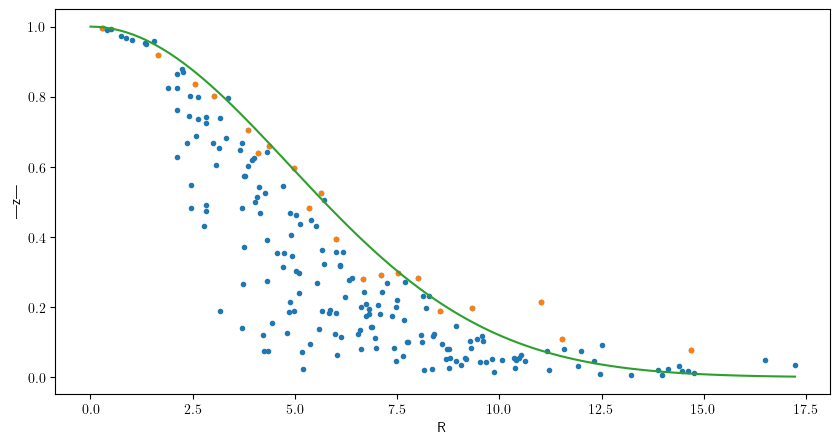

Computing sketch... Done.
Fitting k-means... Done.


In [10]:
# Sketching
X_bounded = (2*X-X.max()-X.min())/(X.max()-X.min()) # bound between -1 and 1
bounds = np.array([-np.ones(p), np.ones(p)])

Sigma = sk.estimate_Sigma(X_bounded, m0=200, n0=X_bounded.shape[0]//10, verbose=1)
Omega = sk.drawFrequencies("FoldedGaussian", p, M, Sigma)
Phi = sk.SimpleFeatureMap("ComplexExponential", Omega)

print("Computing sketch...", end='')
z = sk.computeSketch(X_bounded, Phi)
print(" Done.")

solver = cl.CLOMP_CKM(Phi, k, bounds, z)
print("Fitting k-means...", end='')
solver.fit_once()
print(" Done.")
centroids = solver.get_centroids()

dist = cdist(centroids, X_bounded, metric='euclidean')
y_est[3] = np.argmin(dist, axis=0)
c_err[3], _, _ = utils.get_classif_error(k, y_est[3], y)

# Results

In [11]:
print("{} vs {}".format(num_classes[classes[0]], num_classes[classes[1]]))
print("Offline   \t {:.5%}".format(c_err[0]))
print("Online    \t {:.5%}".format(c_err[1]))
print("Batch     \t {:.5%}".format(c_err[2]))
print("Sketching \t {:.5%}".format(c_err[3]))

Coat vs Ankle boot
Offline   	 3.25000%
Online    	 3.30714%
Batch     	 3.37857%
Sketching 	 3.15000%
